# Itroduction
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

**What?** Generalized Linear and Hierarchical Linear Models

</font>
</div>

# Import modules
<hr style = "border:2px solid black" ></hr>

In [1]:
import os

import arviz as az
import bambi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import xarray as xr

from numpy.random import default_rng

In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
rng = default_rng(RANDOM_SEED)

# Generate dataset
<hr style = "border:2px solid black" ></hr>

In [3]:
size = 50
true_intercept = 1
true_slope = 2
x = np.linspace(0, 1, size)
y = true_intercept + x * true_slope + rng.normal(scale=0.5, size=size)
data = pd.DataFrame({"x": x, "y": y})

In [4]:
data.T

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
x,0.000000,0.020408,0.040816,0.061224,0.081633,0.102041,0.122449,0.142857,0.163265,0.183673,...,0.816327,0.836735,0.857143,0.877551,0.897959,0.918367,0.938776,0.959184,0.979592,1.000000
y,0.888679,1.703646,0.796148,1.456574,1.735956,1.497754,1.219176,0.363190,1.172920,1.361467,...,2.118265,2.479537,2.631910,2.769073,3.541955,2.390332,2.675565,3.103633,3.050290,3.677891


# Linear regression
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- **Bambi** is a high-level Bayesian model-building interface written in Python. It’s built on top of the PyMC3 probabilistic programming framework, and is designed to make it extremely easy to fit mixed-effects models common in social sciences settings using a Bayesian approach.

- We construct a model using Bambi(it uses formula based input), If no priors are given explicitly by the user, then Bambi chooses smart default priors for all parameters of the model based on plausible implied partial correlations between the outcome and the predictors.

</font>
</div>

In [5]:
model = bambi.Model("y ~ x", data)
fitted = model.fit(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, x, Intercept]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


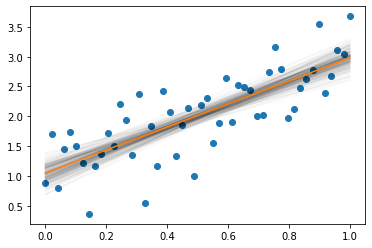

In [6]:
x_axis = xr.DataArray(np.linspace(0, 1, num=100), dims=["x_plot"])
mu_pred = fitted.posterior["Intercept"] + fitted.posterior["x"] * x_axis
mu_mean = mu_pred.mean(dim=("chain", "draw"))
mu_plot = mu_pred.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot.sample)))[:200]
plt.scatter(x, y)
plt.plot(x_axis, mu_plot.isel(sample=random_subset),
         color="black", alpha=0.025)
plt.plot(x_axis, mu_mean, color="C1")

# Robust GLM
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- Lets try the same model but with a few outliers in the data. 

</font>
</div>

In [7]:
#model.graph()

In [8]:
x_out = np.append(x, [0.1, 0.15, 0.2])
y_out = np.append(y, [8, 6, 9])
data_outlier = pd.DataFrame({"x": x_out, "y": y_out})

In [9]:
model = bambi.Model("y ~ x", data_outlier)
fitted = model.fit(draws=1000)
fitted

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, x, Intercept]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

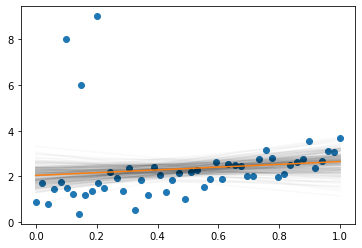

In [10]:
x_axis = xr.DataArray(np.linspace(0, 1, num=100), dims=["x_plot"])
mu_pred = fitted.posterior["Intercept"] + fitted.posterior["x"] * x_axis
mu_mean = mu_pred.mean(dim=("chain", "draw"))
mu_plot = mu_pred.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot.sample)))[:200]
plt.scatter(x_out, y_out)
plt.plot(x_axis, mu_plot.isel(sample=random_subset), color="black", alpha=0.025)
plt.plot(x_axis, mu_mean, color="C1");

<div class="alert alert-info">
<font color=black>

- **Because** the Normal distribution does not have a lot of mass in the tails, an outlier will affect the fit strongly. 
    
- Instead, we can replace the Normal likelihood with a Student T distribution which has heavier tails and is more robust towards outliers. Bambi does not support passing family=”StudentT” yet to indicate a StudentT likelihood, but we can make our own custom Family object 

</font>
</div>

In [11]:
"""
They change the API so I am not sure about my hack
https://bambinos.github.io/bambi/0.6.1/api_reference.html#bambi.families.Family
family = bambi.Family(
    "t", prior=bambi.Prior("StudentT", lam=1, nu=1.5), link="identity", parent="mu"
)
"""

'\nThey change the API so I am not sure about my hack\nhttps://bambinos.github.io/bambi/0.6.1/api_reference.html#bambi.families.Family\nfamily = bambi.Family(\n    "t", prior=bambi.Prior("StudentT", lam=1, nu=1.5), link="identity", parent="mu"\n)\n'

In [12]:
sigma_prior = bambi.Prior("StudentT", lam=1, nu=1.5)

likelihood = bambi.Likelihood("normal", parent="mu", sigma=sigma_prior)

family = bambi.Family("my_gaussian", likelihood, "identity")

In [13]:
model = bambi.Model(
    "y ~ x",
    data_outlier,
    priors={"common": bambi.Prior("HalfNormal", sigma=10)},
    family=family,
)

In [14]:
fitted = model.fit(target_accept=0.9)
x_axis = xr.DataArray(np.linspace(0, 1, num=100), dims=["x_plot"])
mu_pred = fitted.posterior["Intercept"] + fitted.posterior["x"] * x_axis
mu_mean = mu_pred.mean(dim=("chain", "draw"))
mu_plot = mu_pred.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot.sample)))[:200]
plt.scatter(x_out, y_out)
plt.plot(x_axis, mu_plot.isel(sample=random_subset), color="black", alpha=0.025)
plt.plot(x_axis, mu_mean, color="C1");

ValueError: The Distribution 'normal' was not found in PyMC3

# References
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

- https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM.html

</font>
</div>